[Implementation of NICE (Non-Linear Independent Components Estimation)](https://arxiv.org/pdf/1410.8516.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

import os

import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Environment Path Constants you can change
DATASET_PATH = './datasets/'
CHECKPOINT_PATH ='./checkpoints/NICE/'
OUTPUT_PATH = './outputs/NICE/'
CHECKPOINT_FILE = '' #./trained_models/NICE/NICE-MNIST.pt' # If you want to load a checkpoint.
PREPROCESS_PATH = './preprocess/'

# Data Loading Constants (Dependent on your hardware)
DATASET = ['CIFAR10', 'MNIST'][0]
BATCH_SIZE = 200
NUM_WORKERS = 10
PIN_MEMORY = True

# Training Constants
BATCH_PRINT = 50 # Every 50 batches print training progress.
EPOCH_CHECKPOINT = 10 # Every 10 epochs, save a checkpoint.
NUM_EPOCHS = 200
IS_TRAINING= True # Start training a model, unless you want to load a checkpoint instead.

# Set device to gpu by default if available.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# For some reproducibility and determinism (Not gauranteed)
torch.manual_seed(0)
g = torch.Generator()
g.manual_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


print(f'Device: {device}')
print(f'CPU Count: {os.cpu_count()}')
print(f'Number of DataLoading Workers: {NUM_WORKERS}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Dataset: {DATASET}')

Device: cuda:0
CPU Count: 20
Number of DataLoading Workers: 10
Batch Size: 200
Dataset: CIFAR10


### Dequantization
Using the same dequantization method from [RNADE: The real-valued neural autoregressive density-estimator](https://arxiv.org/pdf/1306.0186.pdf), section 4.2 as referenced by NICE.

Without dequantization maximizing the likelihood of our parameters relative to discrete data will result in an arbitrarily high value since the model will "cheat" as the paper describes. With discrete points the distribution would be "spiky" in the continuous space where the width of each of these points approaches 0. So, you can imagine that when we try to maximize the likelihood (in continuous space) the model will just give these points an arbitrary high value in $log(p(x;\theta))$ where $p(x;\theta)$ will have very low probability due to infinitesimal width (discrete) resulting in $log(p(x;\theta)) \rightarrow \infty$ while maintaining the constraint that $\int p(x;\theta) = 1$, hence "cheating".

In [2]:
class Dequantize(nn.Module):
    def __init__(self, device='cpu'):
        super(Dequantize, self).__init__()
        lo = torch.tensor([0.], device=device)
        hi = torch.tensor([1.], device=device)
        self.prior = torch.distributions.Uniform(lo,hi)
        
    def forward(self, x):
        return (x*255 + self.prior.sample(x.shape).squeeze()).divide(256.)

### Data Loading
Only using CIFAR-10 and MNIST dataset for this notebook. However, the paper also uses SVHN. Just flatten and dequantize the data. This also contains some other dataset specific functionalities like preprocessing

In [3]:
# Select Dataset
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    plt.figure(frameon=False)
    img = make_grid(x)
    npimg = img.numpy()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def select_dataset(dataset):
    # Any Dataset pre-processing
    if dataset != 'MNIST':
        mean = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.mean.npy'), dtype=torch.float32, device=device)
        zca = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.zca.npy'), dtype=torch.float32, device=device)
        zca_inv = zca.inverse()
        zca_min = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.zca_min.npy'), dtype=torch.float32, device=device)
        zca_max = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.zca_max.npy'), dtype=torch.float32, device=device)

        preprocess = transforms.Compose([
            transforms.Lambda(lambda x: x - mean), # 0-Mean center
            transforms.Lambda(lambda x: x@zca), # ZCA Whiten
            transforms.Lambda(lambda x: (x - zca_min) / (zca_max - zca_min)) # Rescale            
        ])

        # Invert the pre-processing
        deprocess = transforms.Compose([
            transforms.Lambda(lambda x: (x  * (zca_max - zca_min)) + zca_min),
            transforms.Lambda(lambda x: x@zca_inv),
            transforms.Lambda(lambda x: x + mean)
        ])
    else:
        preprocess = lambda x: x
        deprocess = lambda x: x

    # Setup Dataloaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.flatten()),
    ])
    
    if dataset == 'CIFAR10':
        train_data = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)
    elif dataset == 'MNIST':

        train_data = MNIST(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = MNIST(DATASET_PATH, train=False, download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,1,28,28),title)
    else:
        assert False, f'{dataset} does not exist.'
        
    return train_data, test_data, show_grid, preprocess, deprocess

train_data, test_data, show_grid, preprocess, deprocess = select_dataset(DATASET)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


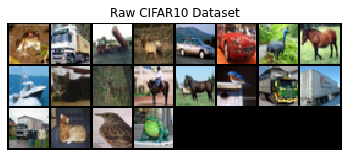

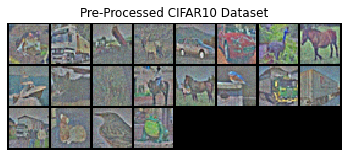

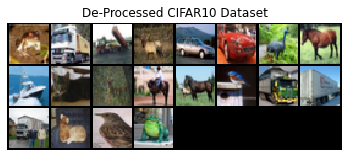

In [4]:
# Setup DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
x = next(iter(train_loader))[0][:20]
show_grid(x, f'Raw {DATASET} Dataset')

x_pre = preprocess(x.to(device)).cpu()
show_grid(x_pre, f'Pre-Processed {DATASET} Dataset')
show_grid(deprocess(x_pre.to(device)).cpu(), f'De-Processed {DATASET} Dataset')

### Maintaining Invertibility
Since our model requires us to calculate the determinant of our jacobian (from Change Of Variables) it is absolutely vital that we seek to maintain this constraint while remaining computationally efficient. See: [What is a Jacobian?](https://www.youtube.com/watch?v=wCZ1VEmVjVo) and [Interpreting Determinant Jacobian](https://www.youtube.com/watch?v=p46QWyHQE6M)

One way to do this is use a simple coupling law on only half of the input. E.g: If we are using the MNIST dataset, then $x^{(i)}_{I_{1}} = [x^{(i)}_{0},x^{(i)}_{2},x^{(i)}_{4},...]$ and $x^{(i)}_{I_{2}} = [x^{(i)}_{1},x^{(i)}_{3},x^{(i)}_{5},...]$ If we do it in this way our jacobian becomes a lower triangular matrix. This would imply that our determinant would simply be the product of the diagonal of this matrix (Review linear algebra basics if you don't know why). The other half will simply be the identity function.

$f(x_{I_{1}}, x_{I_{2}}) = \begin{bmatrix} x_{I_{1}}\newline g(x_{I_{1}}, x_{I_{2}})\end{bmatrix}$

$\triangledown_{x} f = \begin{bmatrix} I & 0 \newline \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{1}}} & \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}}\end{bmatrix}$

$|\triangledown_{x} f| = I \times \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}}$

### Additive Coupling Layer
**Additive Coupling Law:** $g(a;b) = a + b$, where $g:\mathbb{R}^{D-d}\times m(\mathbb{R}^{d}) \rightarrow \mathbb{R}^{D-d}$

We'll use this additive law for each MLP layer where $x_{I_{1}}$ and $x_{I_{2}}$ is the input split in two. 

**Coupling Layer:** 

$z^{(i)}_{I_{1}} = x^{(i)}_{I_{1}}$

$z^{(i)}_{I_{2}} = g(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) = x^{(i)}_{I_{2}} + m(x^{(i)}_{I_{1}})$, where m is a deep neural network (MLP).

**Inverted Coupling Layer:** 

$x^{(i)}_{I_{1}} = z^{(i)}_{I_{1}}$

$x^{(i)}_{I_{2}} = g^{-1}(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) = g(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) - m(x^{(i)}_{I_{1}})$

**Jacobian Determinant of Coupling Layer:**

$|\triangledown_{x} f| = I \times \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = 1$

When using the additive coupling law to transform half of our input, its partial derivative becomes 1. This would imply that our model is "volume preserving" In the sense that with each transformation, the change in volume from $x \rightarrow z$ remains the same.

**Note:**
Stacking these coupling layers in succession requires us to alternate the output of each layer, otherwise only half of the input will actually be processed through all the layers. Therefore, it's important to do this equally on each half. So expect an even number of coupling layers in the model.

In [5]:
# Define Model
import torch.nn.functional as F

def add_coupling(z, m, flip=False, inverse=False):
    n = z.shape[1]
    z = z.reshape(-1, n//2, 2) # Reshaping the tensor in this way results in odd and even indexed inputs in the last dimension.
    
    # Alternate the input
    if flip:
        z2, z1 = z[:,:,0], z[:,:,1]
    else:
        z1, z2 = z[:,:,0], z[:,:,1]
        
    # Invert the coupling law
    if not inverse:
        z2 = z2 + m(z1)
    else:
        z2 = z2 - m(z1)
    
    # Bring it back to its original shape
    if flip: 
        z = torch.stack((z2.unsqueeze(-1),z1.unsqueeze(-1)), dim=2).reshape(-1,n)
    else:
        z = torch.stack((z1.unsqueeze(-1),z2.unsqueeze(-1)), dim=2).reshape(-1,n)
        
    return z

class MLP(torch.nn.Module):
    """ NOTE: Paper uses ReLU with Linear Output Units
    """
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super(MLP, self).__init__()
        model = []
        
        for l in range(num_layers):
            if l == 0:
                model.append(nn.Linear(in_dim, hidden_dim))
                model.append(nn.ReLU())
            elif l == num_layers-1:
                model.append(nn.Linear(hidden_dim, out_dim))
            else:
                model.append(nn.Linear(hidden_dim, hidden_dim))
                model.append(nn.ReLU())
                
        self.mlp = nn.Sequential(*model)
        
    def forward(self, x):
        return self.mlp(x)

In [6]:
# Test to make sure this is working correctly.
z = torch.arange(784, device=device, dtype=torch.float).reshape(1,-1)
m = MLP(392,392,1000,6).to(device)

z_new = add_coupling(z, m, flip=False)
z_new = add_coupling(z_new, m, flip=True)
z_new = add_coupling(z_new, m, flip=False)
z_new = add_coupling(z_new, m, flip=True)
z_recon = add_coupling(z_new, m, flip=True, inverse=True)
z_recon = add_coupling(z_recon, m, flip=False, inverse=True)
z_recon = add_coupling(z_recon, m, flip=True, inverse=True)
z_recon = add_coupling(z_recon, m, flip=False, inverse=True)

print('MSE', ((z - z_recon)**2).mean().cpu().item())

MSE 5.773667134667537e-12


### Scaling
As stated before, since our Jacobian Detetmminant is 1, it is volume preserving. We scale each dimension across the diagonal of the Jacobian by some factor in order to allow for more model variation.

**Note:** If some arbitrary scale approaches $-\infty$ or $\infty$, the dimensionality of this model will approach 1.

In [7]:
# For some reason this has to be a class. I don't know why pytorch requires this to be a class in order for
# the parameter to update. If you just add the parameter to the NICE model, it does not train correcty.

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(
            torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

### Model Definition (Section 5.1)

$h_{I_{1}}^{(1)} = x_{I_{1}}$

$h_{I_{2}}^{(1)} = x_{I_{2}} + m^{(1)}(x_{I_{1}})$

$h_{I_{2}}^{(2)} = h_{I_{2}}^{(1)}$

$h_{I_{2}}^{(2)} = h_{I_{1}}^{(1)} + m^{(2)}(x_{I_{2}})$

$h_{I_{2}}^{(3)} = h_{I_{2}}^{(2)}$

$h_{I_{2}}^{(3)} = h_{I_{2}}^{(2)} + m^{(3)}(x_{I_{1}})$

$h_{I_{2}}^{(4)} = h_{I_{2}}^{(3)}$

$h_{I_{1}}^{(4)} = h_{I_{1}}^{(3)} + m^{(4)}(x_{I_{2}})$

$h= exp(s)\odot h^{(4)}$

where $m$ is the coupling function and h's are the input/outputs.

In [8]:
# Define the main model
def logistic(sample_shape, prior):
    z = prior.sample(sample_shape).squeeze()
    return torch.log(z) - torch.log(1. - z)

def log_logistic(z):
    return -(F.softplus(z) + F.softplus(-z))
    #return -torch.log(1 + torch.exp(z)) - torch.log(1 + torch.exp(-z))

class NICE(torch.nn.Module):
    def __init__(self, num_coupling=4, num_dim=784, num_hidden_units=1000, num_hidden_layers=4, prior_fn=log_logistic, coupling_fn=add_coupling, device='cpu'):
        super(NICE, self).__init__()
        assert num_coupling % 2 == 0, 'We want an even number of swaps.'
        
        self.coupling_fn = add_coupling
        self.prior_fn = log_logistic
        self.mlps = nn.ModuleList([ MLP(num_dim // 2, num_dim // 2, num_hidden_units, num_hidden_layers+2).to(device) for i in range(num_coupling)])
        #self.scaling = nn.Parameter(torch.rand(1, num_dim), requires_grad=True).to(device) # Apparently this has to be not equal to 0, it can't be rand either, it has to be a module.
        self.scaling = Scaling(num_dim)
        self.dequantize = Dequantize(device)
        
    def forward(self, x):
        # Transform to P_x -> P_z
        z = self.dequantize(x)
        for i, m in enumerate(self.mlps):
            z = self.coupling_fn(z, m, flip=(i%2 != 0), inverse=False)
        
        #z = torch.exp(self.scaling) * z
        #logdet = self.scaling
        z, logdet = self.scaling(z)
        logprior = log_logistic(z)
        
        return logprior, logdet
    
    def sample(self, sample_shape=(64,784)):
        return self.inverse(logistic(sample_shape))

    def inverse(self, z):
        x = z
        x, _ = self.scaling(x, reverse=True)

        for i, m in reversed(list(enumerate(self.mlps))):
            x = self.coupling_fn(x, m, flip=(i%2 != 0 ), inverse=True)
        return x

### Log Likelihood

Recall the change of variable:

$p_{X}(x) = p_{H}(f(x))|det\dfrac{\partial f(x)}{\partial x}|$, where $p_{H}$ is our prior (Logistic Distribution), and $p_{X}$ is the distribution of our dataset.

In NICE, we assume that each component, $h_{d}$ is independent and so $p_{H}$ factorizes into $p_{H}(h) = \prod_{d}p_{H_{d}}(h_{d})$.

And so now we simply maximize the log likelihood using the change of variable likeso:

$log(p_{X}(x)) = \sum_{d=1}^{D}log(p_{H_{d}}(f_{d}(x))) + log(|det(\dfrac{\partial f(x)}{\partial x})|)$

This is now:

$log(p_{X}(x)) = \sum_{d=1}^{D}log(p_{H_{d}}(f_{d}(x))) + log(|S_{ii}|)$, where $S_{ii}$ are the learned scaling parameters used in conjunction with the unit determinant jocabian of the additive coupling layers.



In [9]:
# Loss Function.
def log_likelihood(logprior, logdet):
    return logprior.sum(dim=1) + logdet

### Hyper Parameters
![Section 5.1](./images/NICE_hyperparameters.JPG)

Section 5.1 in the paper.

**Note:** Not using ZCA in this notebook. If you want it, add it to to DataLoader preprocessing.

In [10]:
from torch import optim

# Model Configuration
if DATASET == 'MNIST':
    hyper_parameters = {
        'num_dim': 784,
        'num_hidden_units':1000,
        'device': device
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,784)
    img_shape = (1,28,28)
elif DATASET == 'CIFAR10':
    hyper_parameters = {
        'num_dim': 3072,
        'num_hidden_units': 2000,
        'device': device    
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,3072)
    img_shape = (3,32,32)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-4)

### Load Checkpoint
If available...

In [11]:
if CHECKPOINT_FILE != '':
    ckpt = torch.load(CHECKPOINT_FILE)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    epoch = ckpt['epoch']

### Training

Epochs: [0/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: 4453.080078125
Running Batch Time: 0.49213457107543945
Epochs: [0/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: 5680.895651424632
Running Batch Time: 0.027489629446291457
Epochs: [0/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: 4974.111332959468
Running Batch Time: 0.02281882031129138
Epochs: [0/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: 4699.779924203229
Running Batch Time: 0.02124339539483683
Epochs: [0/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: 4533.3229069496265
Running Batch Time: 0.02047283258011092
Saving ./checkpoints/NICE/NICE-CIFAR10-2021-09-29_01:54:02-0.pt.
Saving ./outputs/NICE/NICE-CIFAR10-2021-09-29_01:54:02-0-3875.93798828125.jpg


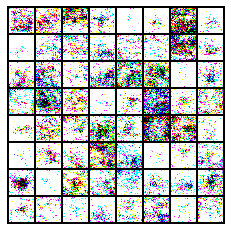

Training Likelihood: -4414.667716796875	Test Likelihood: -3874.022216796875
Epochs: [1/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: 3874.12158203125
Running Batch Time: 2.245065450668335
Epochs: [1/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: 3818.1712191712622
Running Batch Time: 0.06206715340707816
Epochs: [1/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: 3760.854277053682
Running Batch Time: 0.04042252691665498
Epochs: [1/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: 3702.22590445209
Running Batch Time: 0.033076573681357684
Epochs: [1/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: 3642.4289441464553
Running Batch Time: 0.029342550543410267
Training Likelihood: -3582.8468701171873	Test Likelihood: -3275.479736328125
Epochs: [2/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: 3275.62548828125
Running Batch Time: 1.1106765270233154
Epochs: [2/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: 3211.59

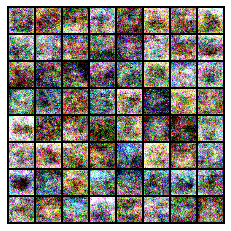

Training Likelihood: 1511.11216015625	Test Likelihood: 1762.5526123046875
Epochs: [11/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -1757.886474609375
Running Batch Time: 2.2155072689056396
Epochs: [11/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -1812.4284117455577
Running Batch Time: 0.06132921518064013
Epochs: [11/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -1858.8189938989017
Running Batch Time: 0.03994418606899752
Epochs: [11/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -1904.482414599286
Running Batch Time: 0.03273355250327003
Epochs: [11/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -1950.4394755956546
Running Batch Time: 0.029121198464388872
Training Likelihood: 1994.8137065429687	Test Likelihood: 2213.284912109375
Epochs: [12/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -2206.56005859375
Running Batch Time: 1.1083428859710693
Epochs: [12/200]	Batches: [51/250]	Samples: [10200/50000]	Running L

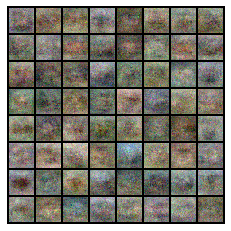

Training Likelihood: 3410.4381826171875	Test Likelihood: 3409.613525390625
Epochs: [21/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3391.3583984375
Running Batch Time: 2.2936973571777344
Epochs: [21/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3423.7424555759803
Running Batch Time: 0.06345060292412252
Epochs: [21/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3417.364656656095
Running Batch Time: 0.04117085910079503
Epochs: [21/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3415.297573468543
Running Batch Time: 0.033714185487355615
Epochs: [21/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3417.832472160681
Running Batch Time: 0.029908033152717856
Training Likelihood: 3422.4616572265627	Test Likelihood: 3416.859619140625
Epochs: [22/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3399.654296875
Running Batch Time: 1.1313252449035645
Epochs: [22/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss:

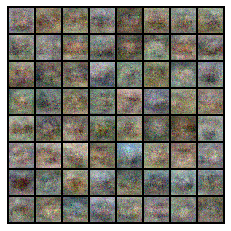

Training Likelihood: 3468.9883896484375	Test Likelihood: 3443.28955078125
Epochs: [31/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3441.669189453125
Running Batch Time: 2.2310006618499756
Epochs: [31/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3471.596852022059
Running Batch Time: 0.061822218053481155
Epochs: [31/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3467.87093904703
Running Batch Time: 0.04031299364448774
Epochs: [31/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3464.521736599752
Running Batch Time: 0.03312102216758475
Epochs: [31/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3467.1362061761506
Running Batch Time: 0.029413362047565516
Training Likelihood: 3471.3159169921873	Test Likelihood: 3441.955810546875
Epochs: [32/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3442.593994140625
Running Batch Time: 1.1524019241333008
Epochs: [32/200]	Batches: [51/250]	Samples: [10200/50000]	Running Lo

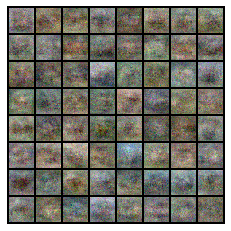

Training Likelihood: 3491.992041015625	Test Likelihood: 3450.718994140625
Epochs: [41/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3459.5869140625
Running Batch Time: 2.217629909515381
Epochs: [41/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3494.7899576822915
Running Batch Time: 0.06188777381298589
Epochs: [41/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3491.0979414836015
Running Batch Time: 0.04041865792604956
Epochs: [41/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3487.107601342612
Running Batch Time: 0.03316930587718029
Epochs: [41/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3489.9388506685323
Running Batch Time: 0.0294962332616398
Training Likelihood: 3493.8621279296876	Test Likelihood: 3442.813232421875
Epochs: [42/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3450.2578125
Running Batch Time: 1.124720811843872
Epochs: [42/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3495

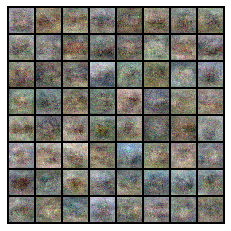

Training Likelihood: 3510.126345703125	Test Likelihood: 3459.564697265625
Epochs: [51/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3479.87744140625
Running Batch Time: 2.255533218383789
Epochs: [51/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3512.059824027267
Running Batch Time: 0.06231400078418208
Epochs: [51/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3507.788143951114
Running Batch Time: 0.040522655638137665
Epochs: [51/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3505.913305825745
Running Batch Time: 0.03316646853819588
Epochs: [51/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3508.774010805348
Running Batch Time: 0.02947152431924545
Training Likelihood: 3512.144560546875	Test Likelihood: 3459.4619140625
Epochs: [52/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3478.142333984375
Running Batch Time: 1.126011610031128
Epochs: [52/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -35

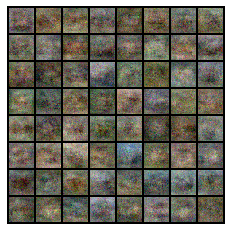

Training Likelihood: 3526.6244755859375	Test Likelihood: 3461.392333984375
Epochs: [61/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3492.68212890625
Running Batch Time: 2.2448973655700684
Epochs: [61/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3529.1221516927085
Running Batch Time: 0.062239586138257794
Epochs: [61/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3522.9354477684096
Running Batch Time: 0.040564869890118586
Epochs: [61/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3521.0556672961507
Running Batch Time: 0.03322477056490664
Epochs: [61/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3523.748339600824
Running Batch Time: 0.029605324588604827
Training Likelihood: 3527.1617880859376	Test Likelihood: 3461.984619140625
Epochs: [62/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3493.1015625
Running Batch Time: 1.1094565391540527
Epochs: [62/200]	Batches: [51/250]	Samples: [10200/50000]	Running Los

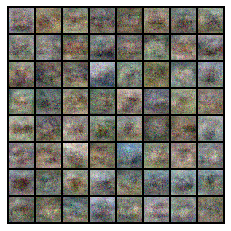

Training Likelihood: 3543.1499609375	Test Likelihood: 3463.29541015625
Epochs: [71/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3504.706787109375
Running Batch Time: 2.2281672954559326
Epochs: [71/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3544.6777152267155
Running Batch Time: 0.06209819924597647
Epochs: [71/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3541.233185720916
Running Batch Time: 0.040587106553634796
Epochs: [71/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3538.2230297366514
Running Batch Time: 0.03332319322800794
Epochs: [71/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3539.742402489506
Running Batch Time: 0.029661521389709775
Training Likelihood: 3543.0720537109373	Test Likelihood: 3467.86865234375
Epochs: [72/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3508.87158203125
Running Batch Time: 1.1092705726623535
Epochs: [72/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss:

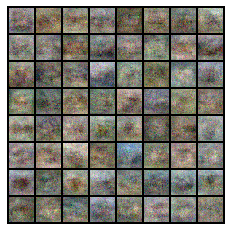

Training Likelihood: 3554.6973359375	Test Likelihood: 3463.795166015625
Epochs: [81/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3517.456787109375
Running Batch Time: 2.216499090194702
Epochs: [81/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3553.430410347733
Running Batch Time: 0.06147203725927016
Epochs: [81/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3550.5487942837253
Running Batch Time: 0.040107224247243146
Epochs: [81/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3547.3363190707782
Running Batch Time: 0.0328856919774946
Epochs: [81/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3550.3229081642567
Running Batch Time: 0.029248782058260335
Training Likelihood: 3554.0524287109374	Test Likelihood: 3466.451904296875
Epochs: [82/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3519.279541015625
Running Batch Time: 1.1110060214996338
Epochs: [82/200]	Batches: [51/250]	Samples: [10200/50000]	Running Los

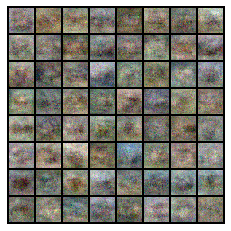

Training Likelihood: 3561.574310546875	Test Likelihood: 3468.18994140625
Epochs: [91/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3528.202392578125
Running Batch Time: 2.235835552215576
Epochs: [91/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3567.4570695465686
Running Batch Time: 0.06186201993156882
Epochs: [91/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3562.4987116143257
Running Batch Time: 0.04033132590869866
Epochs: [91/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3558.2348697485513
Running Batch Time: 0.03307866102812306
Epochs: [91/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3559.0153990788244
Running Batch Time: 0.029388090864342836
Training Likelihood: 3563.0930263671876	Test Likelihood: 3471.511962890625
Epochs: [92/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3532.018310546875
Running Batch Time: 1.107792615890503
Epochs: [92/200]	Batches: [51/250]	Samples: [10200/50000]	Running Lo

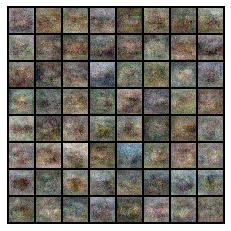

Training Likelihood: 3573.486314453125	Test Likelihood: 3467.5703125
Epochs: [101/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3536.0126953125
Running Batch Time: 2.2273805141448975
Epochs: [101/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3573.39892578125
Running Batch Time: 0.061790844973395855
Epochs: [101/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3567.9647978225557
Running Batch Time: 0.04035412911141273
Epochs: [101/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3565.6105067777316
Running Batch Time: 0.0332326004836733
Epochs: [101/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3568.3640914081934
Running Batch Time: 0.02951653086723973
Training Likelihood: 3572.1532421875	Test Likelihood: 3469.2431640625
Epochs: [102/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3537.2646484375
Running Batch Time: 1.106743574142456
Epochs: [102/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -357

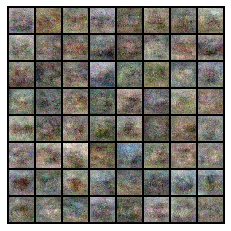

Training Likelihood: 3580.9967861328123	Test Likelihood: 3466.07861328125
Epochs: [111/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3541.677978515625
Running Batch Time: 2.4192588329315186
Epochs: [111/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3585.957404641544
Running Batch Time: 0.06577707739437327
Epochs: [111/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3579.010036355198
Running Batch Time: 0.04240140820493792
Epochs: [111/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3575.2241340283526
Running Batch Time: 0.03450243994100204
Epochs: [111/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3578.3737064190764
Running Batch Time: 0.030473093488323156
Training Likelihood: 3582.10423046875	Test Likelihood: 3467.1669921875
Epochs: [112/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3544.4091796875
Running Batch Time: 1.0991201400756836
Epochs: [112/200]	Batches: [51/250]	Samples: [10200/50000]	Running 

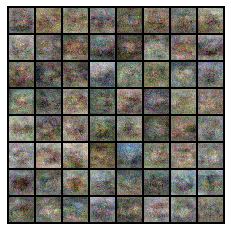

Training Likelihood: 3587.6730166015627	Test Likelihood: 3468.64990234375
Epochs: [121/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3551.51220703125
Running Batch Time: 2.2670071125030518
Epochs: [121/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3590.6025390625
Running Batch Time: 0.062485727609372606
Epochs: [121/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3585.3785847578897
Running Batch Time: 0.04062613166204774
Epochs: [121/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3582.5595250413908
Running Batch Time: 0.033246651390530416
Epochs: [121/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3584.0698898087685
Running Batch Time: 0.029552623407164618
Training Likelihood: 3587.1834951171877	Test Likelihood: 3466.234375
Epochs: [122/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3549.794677734375
Running Batch Time: 1.1079490184783936
Epochs: [122/200]	Batches: [51/250]	Samples: [10200/50000]	Running 

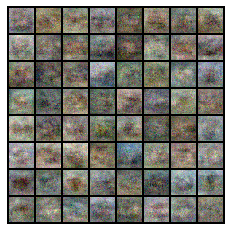

Training Likelihood: 3591.0906982421875	Test Likelihood: 3457.967529296875
Epochs: [131/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3545.873291015625
Running Batch Time: 2.228795051574707
Epochs: [131/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3590.474714690564
Running Batch Time: 0.06203912286197438
Epochs: [131/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3585.730954614016
Running Batch Time: 0.04040917783680529
Epochs: [131/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3583.804629294288
Running Batch Time: 0.0330953345393503
Epochs: [131/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3587.4389454096704
Running Batch Time: 0.029445713432274055
Training Likelihood: 3591.558203125	Test Likelihood: 3459.212646484375
Epochs: [132/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3549.7265625
Running Batch Time: 1.142958164215088
Epochs: [132/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: 

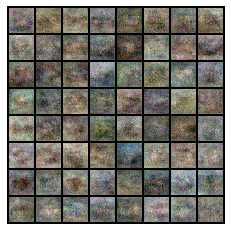

Training Likelihood: 3597.7306123046874	Test Likelihood: 3465.62939453125
Epochs: [141/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3561.427734375
Running Batch Time: 2.232947587966919
Epochs: [141/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3603.3391161151962
Running Batch Time: 0.061833858489990234
Epochs: [141/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3597.2336087368503
Running Batch Time: 0.040289621541995814
Epochs: [141/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3592.6446201753934
Running Batch Time: 0.03296446642338835
Epochs: [141/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3595.211243586754
Running Batch Time: 0.029304907689640176
Training Likelihood: 3599.1665341796875	Test Likelihood: 3462.21240234375
Epochs: [142/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3558.97119140625
Running Batch Time: 1.1019160747528076
Epochs: [142/200]	Batches: [51/250]	Samples: [10200/50000]	Runni

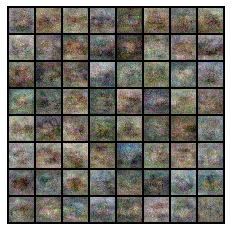

Training Likelihood: 3597.8209912109373	Test Likelihood: 3455.17431640625
Epochs: [151/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3557.18017578125
Running Batch Time: 2.2507920265197754
Epochs: [151/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3600.6639619715074
Running Batch Time: 0.06226621889600567
Epochs: [151/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3597.929776937655
Running Batch Time: 0.04044553548982828
Epochs: [151/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3595.2574341628724
Running Batch Time: 0.03322264690272855
Epochs: [151/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3597.7741917852145
Running Batch Time: 0.029646866357148582
Training Likelihood: 3601.19627734375	Test Likelihood: 3454.433837890625
Epochs: [152/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3560.060546875
Running Batch Time: 1.1834924221038818
Epochs: [152/200]	Batches: [51/250]	Samples: [10200/50000]	Running

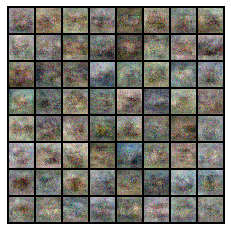

Training Likelihood: 3603.6284658203126	Test Likelihood: 3455.891845703125
Epochs: [161/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3566.638916015625
Running Batch Time: 2.310084581375122
Epochs: [161/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3604.406364889706
Running Batch Time: 0.06329153098312079
Epochs: [161/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3598.723173538057
Running Batch Time: 0.04104384809437365
Epochs: [161/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3596.4350472759725
Running Batch Time: 0.03350772447143959
Epochs: [161/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3599.454433156483
Running Batch Time: 0.029732147852579754
Training Likelihood: 3603.546353515625	Test Likelihood: 3456.184814453125
Epochs: [162/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3563.42236328125
Running Batch Time: 1.1123120784759521
Epochs: [162/200]	Batches: [51/250]	Samples: [10200/50000]	Runni

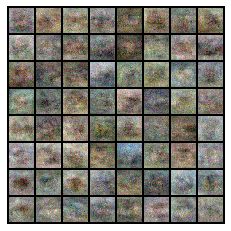

Training Likelihood: 3604.2547197265626	Test Likelihood: 3454.03271484375
Epochs: [171/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3559.888916015625
Running Batch Time: 2.240091323852539
Epochs: [171/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3605.0356110217526
Running Batch Time: 0.06223100306941014
Epochs: [171/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3601.6873525487313
Running Batch Time: 0.04052420181803184
Epochs: [171/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3598.7388196528354
Running Batch Time: 0.03335355764982716
Epochs: [171/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3601.7455374494716
Running Batch Time: 0.029644114461111194
Training Likelihood: 3606.03932421875	Test Likelihood: 3453.860595703125
Epochs: [172/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3563.7880859375
Running Batch Time: 1.1349146366119385
Epochs: [172/200]	Batches: [51/250]	Samples: [10200/50000]	Runni

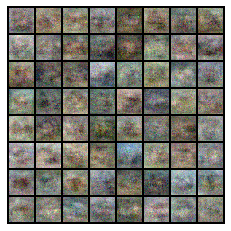

Training Likelihood: 3612.7848076171877	Test Likelihood: 3454.44580078125
Epochs: [181/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3570.5498046875
Running Batch Time: 2.2524173259735107
Epochs: [181/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3614.83709118413
Running Batch Time: 0.06241677321639715
Epochs: [181/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3608.495547455136
Running Batch Time: 0.04062294960021973
Epochs: [181/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3605.9661436775664
Running Batch Time: 0.033306317613614314
Epochs: [181/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3608.684705136427
Running Batch Time: 0.02960744900489921
Training Likelihood: 3612.295208984375	Test Likelihood: 3456.34228515625
Epochs: [182/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3571.817626953125
Running Batch Time: 1.0970089435577393
Epochs: [182/200]	Batches: [51/250]	Samples: [10200/50000]	Running 

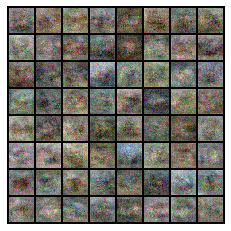

Training Likelihood: 3612.2200576171876	Test Likelihood: 3453.679931640625
Epochs: [191/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3571.24560546875
Running Batch Time: 2.2224395275115967
Epochs: [191/200]	Batches: [51/250]	Samples: [10200/50000]	Running Loss: -3614.4441157322303
Running Batch Time: 0.061698287141089346
Epochs: [191/200]	Batches: [101/250]	Samples: [20200/50000]	Running Loss: -3608.8761433516397
Running Batch Time: 0.04024820516605188
Epochs: [191/200]	Batches: [151/250]	Samples: [30200/50000]	Running Loss: -3604.995822123344
Running Batch Time: 0.03293905037128373
Epochs: [191/200]	Batches: [201/250]	Samples: [40200/50000]	Running Loss: -3606.5092469780006
Running Batch Time: 0.02931672660865594
Training Likelihood: 3610.0174951171875	Test Likelihood: 3451.98876953125
Epochs: [192/200]	Batches: [1/250]	Samples: [200/50000]	Running Loss: -3570.39794921875
Running Batch Time: 1.1298828125
Epochs: [192/200]	Batches: [51/250]	Samples: [10200/50000]	Running L

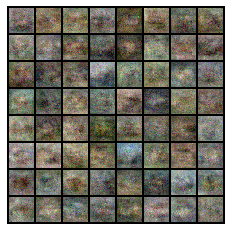

Training Likelihood: 3613.365748046875	Test Likelihood: 3446.8408203125


In [12]:
from torchvision.utils import save_image
from datetime import datetime
from meters import LossMeter, HWMeter

# Generate a fixed point in logistic space to invert across training. Allows us to see progress.
lo = torch.tensor([0.], device=device)
hi = torch.tensor([1.], device=device)
prior = torch.distributions.Uniform(lo,hi)
fixed_sample = logistic(sample_shape, prior)

# Record the inverse during training for visualization purposes
inverse_records = []
batch_rate = 4
max_iters = 300
rec_iter = 0
# Local training variables
train_lls = []
test_lls = []
epoch = 0
loss_meter = LossMeter(NUM_EPOCHS, len(train_loader), BATCH_SIZE, len(train_loader.dataset))
hw_meter = HWMeter(device)
while epoch < NUM_EPOCHS and IS_TRAINING:
        
        # Train Loop
        model.train()
        for i, (x,y) in enumerate(train_loader):
            for param in model.parameters():
                param.grad = None
                
            x = preprocess(x.to(device))

            logprior, logdet = model(x)
            nll = -log_likelihood(logprior, logdet).mean()
            nll.backward()
            
            optimizer.step() 
            loss_meter.step(nll.item(), i, epoch)
            hw_meter.step(i)
            
            # Print some information
            if i % BATCH_PRINT == 0:
                loss_meter.print()
                hw_meter.print()
                
                # Record Inverse
                if rec_iter < max_iters:
                    with torch.no_grad():
                        sample = deprocess(model.inverse(fixed_sample))
                        inverse_records.append((sample.detach(), epoch, i, -loss_meter.running_loss / (i+1)))
                    rec_iter += 1
        train_ll = -loss_meter.running_loss / len(train_loader)
        
        # Test Loop
        model.eval()
        with torch.no_grad():
            test_ll = 0.
            for i, (x,y) in enumerate(test_loader):
                x = preprocess(x.to(device))
                logprior, logdet = model(x)
                ll = log_likelihood(logprior, logdet).sum()
                test_ll += ll
        test_ll /= len(test_loader.dataset)
        
        # Save Likelihoods
        train_lls.append(train_ll)
        test_lls.append(test_ll.item())

        # Store a Checkpoint
        if epoch % EPOCH_CHECKPOINT == 0 or epoch == NUM_EPOCHS-1:
            time = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            ckptpath = f'{CHECKPOINT_PATH}NICE-{DATASET}-{time}-{epoch}.pt'
            torch.save({
                        'epoch': epoch,
                        'dataset': DATASET,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_ll': train_ll,
                        'test_ll': test_ll.item(),
                        **hyper_parameters
                        }, ckptpath)
            print(f'Saving {ckptpath}.')

            # Save a sample
            outpath = f'{OUTPUT_PATH}NICE-{DATASET}-{time}-{epoch}-{nll}.jpg'
            model.eval()
            with torch.no_grad():
                samples = deprocess(model.inverse(fixed_sample))
            print(f'Saving {outpath}')
            grid = make_grid(samples.reshape(((-1,)+img_shape)).detach().cpu().clamp(0, 1))
            show(grid)
            plt.show()
            
        epoch += 1
        loss_meter.reset()
        hw_meter.reset()
        
        print(f'Training Likelihood: {train_ll}\tTest Likelihood: {test_ll}')


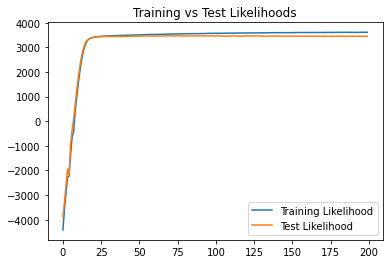

In [14]:
import imageio
import io

if IS_TRAINING:
    plt.figure()
    plt.title('Training vs Test Likelihoods')
    plt.plot(train_lls, label='Training Likelihood')
    plt.plot(test_lls, label='Test Likelihood')
    plt.legend()
    
    # Save Gif
    images = []
    for inv, epoch, batch, ll in inverse_records:
        grid = np.moveaxis(make_grid(inv.reshape(((-1,)+img_shape)).cpu()).clamp(0,1).numpy(),0,-1)
        fig = plt.figure(frameon=False)
        c,h,w = grid.shape
        fig.set_size_inches(3,3)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        plt.imshow(grid)
        
        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='raw',)
        w, h = fig.canvas.get_width_height()
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),newshape=(h,w, -1))
        io_buf.close()
        plt.close()
        images.append(img_arr)
    imageio.mimsave(f'NICE-{DATASET}.gif', images, duration = .05)


### Samples
Some random samples in logistic space inverted to data space.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


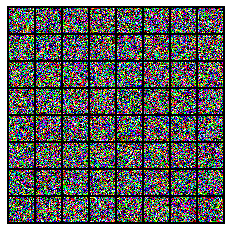

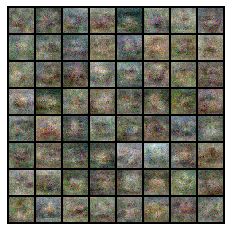

In [18]:
samples = logistic(sample_shape, prior)

grid = show_grid(samples.reshape(((-1,)+img_shape)).detach().cpu())
samples = deprocess(model.inverse(samples))
grid = show_grid(samples.reshape(((-1,)+img_shape)).detach().cpu())